In [8]:
import time
import math

import random
import numpy as np
import matplotlib.pyplot as plt

import argparse
from tqdm import tqdm

In [2]:
def read_data(data_path, show=False):
    """Read the specified data (KQBF problem)"""
    # data_path = "./instances/kqbf/kqbf020"

    with open(data_path, "r") as file:
        lines = file.readlines()

    N = int(lines[0].strip())
    W = int(lines[1].strip())
    w = list(map(int, lines[2].strip().split()))
    A = []

    for i in range(N):
        row = list(map(int, lines[i + 3].strip().split()))
        A.append(row)

    max_length = max(len(sublist) for sublist in A)
    for sublist in A:
        sublist.extend([0] * (max_length - len(sublist)))

    matrix = np.zeros((max_length, max_length))
    for i in range(max_length):
        for j in range(i + 1):
            matrix[i][j] = A[i][j]
            matrix[j][i] = A[i][j]

    if show:
        print("N:", N)
        print("W:", W)
        print("w:", w)
        print("A:")
        for row in A:
            print(row)

    return N, W, np.array(w), np.array(matrix)

In [23]:
def objective_function(x, A):
    return np.dot(x, np.dot(A, x.T))

# Definindo a restrição do problema
def constraint(x, w, W):
    return np.dot(x, w) <= W

def initialize_solution(n):
    """Initialize the solution using a random strategy"""
    x = np.random.randint(2, size=n)
    return np.array(x)

In [24]:
initialize_solution(20)

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [44]:
# Tabu
def get_best_neighbour(x, A, w, W, tabu_history, tabu_limit, aspiration):
    best_neighbour = None
    best_neighbour_cost = -math.inf  # Change this line
    # generate a list of all possible neighbours
    for i in range(len(x)):
        # Flip the ith bit
        tmp_solution = x.copy()
        tmp_solution[i] = 1 - tmp_solution[i]  # flip the bit
        tmp_cost = objective_function(tmp_solution, A)

        # This solution is tabu, check aspiration
        if tuple(tmp_solution) in tabu_history:
            if tabu_history[tuple(tmp_solution)] > 0:
                if tabu_history[tuple(tmp_solution)] > aspiration:
                    continue

        # Check the constraint
        if constraint(tmp_solution, w, W):
            if tmp_cost > best_neighbour_cost: 
                best_neighbour_cost = tmp_cost
                best_neighbour = tmp_solution
                tabu_history[tuple(best_neighbour)] = tabu_limit

    return best_neighbour

def tabu_search(
    x,
    A,
    w,
    W,
    initial_solution,
    num_iter,
    tabu_history,
    tabu_limit,
    aspiration,
    cost_function,
    neighbour_function,
    use_historical_best=False,
    use_tqdm = False
):
    best_solution = initial_solution
    historical_best = best_solution
    historical_best_cost = cost_function(best_solution, A)
    best_cost = cost_function(best_solution, A)
    states = [best_cost]
    if use_tqdm:
        pbar = tqdm(total=num_iter)
    for _ in range(num_iter):
        # Reduce counter for all tabu
        if use_tqdm: pbar.update()
        for x in tabu_history:
            tabu_history[x] -= 1
        tabu_history = {x: tabu_history[x] for x in tabu_history if tabu_history[x] > 0}

        best_solution = neighbour_function(
            best_solution, A, w, W, tabu_history, tabu_limit, aspiration
        )
        best_cost = cost_function(best_solution, A)
        if (best_cost >= historical_best_cost): # and (constraint(best_solution, w, W)):
            historical_best = best_solution
            historical_best_cost = best_cost
        states.append(best_cost)
    if not use_historical_best:
        return best_solution, best_cost, states
    else:
        return historical_best, historical_best_cost, states


[12 16  4  2 11 14  2 15  6  2  8  2 14 16 11 14 10  0 20 14  1  3 17 11
  2 16  6 19  9 20 14 17  2 14 11 17  3 14 10 15 14 19 17 14 13 15 19  7
 13  0  7  6 20 12 18 10 10 11  9 16 14 19 13  6 12  6 13  5 10  3 17  7
 20 17  2  6 11  3  7 10 19  6  9  1 12 18 16  7  6  4  3 13  6  9 14  7
  6  3  6  9  8  9 20 17  6 10  6 18  9 10  4 11 13 19 16 16 15  1  6  0
  0  2  5 10  7  8  4 11 13 18  9  5 12 17  4 10 20 17  1  6 13  5 11 14
  4 16  9  2 17  5 13  4 20 20  5  0 19  8 14 15 11  6  9 11 11  2 20 13
 20 13  9 10  5 15  4  4 18  1 12 16  2  9 10 11  7 17 19 17 11  4 12 19
 19  8  1  2  5  1  9  1 13 11  0  8  3  6  2 10 17 16  3 14  0 15  9  2
 18 10  1 20 13  5  1  1 11  3  4 12  7 11 14 10 18  3  0 14  9  9 11  9
 19  2 11  5  6  9 16 20 20  8 19 15  8  2  5 11 16 13 19  3  0  9 13 15
  0 16  7 18 15  0 10 20 11 11  7  5  1 11  0  7 18  9  7 19  6 16  5 19
  2 12  9  8 12 15  4 14 15 19 19  7  4  3 17  5 20 13  6  4  3 18 18 13
 11  6 17  9  2  0 12  2 10 10 16  1  5 11 12  7  0

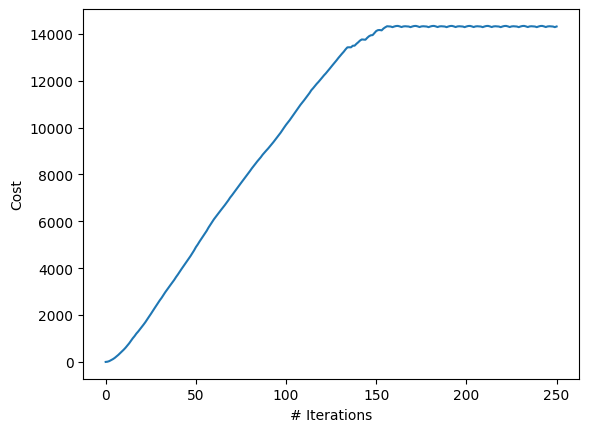

In [53]:
problem_instance = "kqbf400" # args.problem_instance
N, W, w, A = read_data(data_path=f"./instances/kqbf/{problem_instance}", show=False)
w = np.array(w)

print(w)
print(W)
print()

# Initialize the tabu search parameters
# initial_solution = initialize_solution(N)
initial_solution = np.zeros(N, dtype=int)
# print(initial_solution)
num_iter = 250
tabu_history = {}
tabu_limit = 5
aspiration = -np.inf

# Run the tabu search
best_solution, best_cost, states = tabu_search(
    initial_solution=initial_solution,
    num_iter=num_iter,
    tabu_history=tabu_history,
    tabu_limit=tabu_limit,
    aspiration=aspiration,
    cost_function=objective_function,
    neighbour_function=get_best_neighbour,
    x=initial_solution,
    A=A,
    w=w,
    W=W,
    use_historical_best=True,
    use_tqdm=False
)

print(f"Best solution: {best_solution}")
print(f"Best cost: {best_cost}")
print(f"Constraint is True?: {constraint(best_solution, w, W)}")


plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.plot(states)
plt.show()